In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import tabulate as tab

#Create dataset using pandas
df = pd.read_excel(r"C:\DS\NBA_player_data.xlsx").set_index('Name').astype(float) #Convert all columns except for Name to float type
df = df.reset_index() #Reset the index
df.info()

c:\Users\rliu2\anaconda3\lib\site-packages\sklearn\utils\__init__.py:21: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.6)
  from scipy.sparse import issparse


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 91 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          250 non-null    object 
 1   Age           250 non-null    float64
 2   MP            250 non-null    float64
 3   GP            250 non-null    float64
 4   MPG           250 non-null    float64
 5   FGM           250 non-null    float64
 6   FGA           250 non-null    float64
 7   FG%           250 non-null    float64
 8   3PM           250 non-null    float64
 9   3PA           250 non-null    float64
 10  3P%           250 non-null    float64
 11  FTM           250 non-null    float64
 12  FTA           250 non-null    float64
 13  FT%           250 non-null    float64
 14  ORB           250 non-null    float64
 15  DRB           250 non-null    float64
 16  REB           250 non-null    float64
 17  AST           250 non-null    float64
 18  STL           250 non-null    

In [2]:
df.head()
#Change the Name feature to not include team and position
def edit_string(name):
    if name[-1] == 'C':
        return name[:-7] #If the player is a Center, the last 7 letters need to be deleted (3 letter team abbreviation + space + vertical line + space + C)
    else:
        return name[:-8] #If the player isn't a center, their position is two letters, so the last 8 letters need to be deleted

df['Name'] = df['Name'].apply(edit_string)


In [3]:
#Print all rows with null values
null_df = df[df.isnull().any(axis=1)]
print(null_df)

                 Name   Age      MP    GP   MPG  FGM   FGA    FG%  3PM  3PA  \
0       DeMar DeRozan  35.0  2989.0  79.0  37.8  8.2  17.2  0.480  0.9  2.8   
1    Domantas Sabonis  28.0  2928.0  82.0  35.7  7.7  13.0  0.594  0.4  1.1   
2          Coby White  25.0  2881.0  79.0  36.5  6.8  15.3  0.447  2.6  7.0   
3       Mikal Bridges  28.0  2854.0  82.0  34.8  6.9  15.8  0.436  2.7  7.2   
4      Paolo Banchero  22.0  2799.0  80.0  35.0  8.0  17.6  0.455  1.5  4.4   
..                ...   ...     ...   ...   ...  ...   ...    ...  ...  ...   
245     James Wiseman  23.0  1091.0  63.0  17.3  3.0   4.8  0.613  0.0  0.0   
246        Dante Exum  29.0  1088.0  55.0  19.8  2.9   5.5  0.533  1.0  2.0   
247       Sam Merrill  28.0  1069.0  61.0  17.5  2.6   6.4  0.402  2.3  5.8   
248    Shaedon Sharpe  21.0  1059.0  32.0  33.1  5.5  13.6  0.406  1.9  5.6   
249      Dennis Smith  27.0  1059.0  56.0  18.9  2.6   6.0  0.435  0.6  1.9   

     ...  Pnrr%  PnrrPPP  OffScreen%  OffScreenPPP 

There are a lot of null values in the dataset. Therefore, we must first narrow down the important features in determining NBA players that are the most similar to LeBron James before preparing the data for clustering. 

To determine how similar a player is to Lebron James, I want to look at these nine factors: Physical Attributes, Usage & Playmaking, Shooting Tendencies, Shooting Ability, Portability, Passing Ability, Defense Ability, and Dominance. 

To evaluate these factors, these are the features I selected, which should provide the most aggregate overview of each factor, and doesn't have repeated information. 

Physical attributes: Height, Weight, Wingspan  

Usage & Playmaking: BC (Box Creation), USG % (Usage Percentage), LOAD (Offensive Load)  

Shooting tendencies: Less than 5ft FGA%, 5-9 ft FGA%, 10-14 ft FGA%, 15-19 ft FGA%, 20-25 ft FGA%, 25-29ft FGA%

Shooting ability: SQ (Shooting Quality), TS% (True Shooting %)  

Portability: PORT(Portability)  

Passing ability: PR (Passer rating)  

Defense: VR (Defensive Versatility Rating), CDPM (Defensive Crafted Plus Minus)  

Dominance: CPM (Crafted Plus Minus)  

Playstyle: Handoff%, Cut%, Iso%, Prbh%, Post%, Pnrr%, OffScreen%, SpotUp%  



To add Shooting tendencies data into the dataframe, we will get the data from a different website (https://www.nba.com/stats/players/shooting?PerMode=Totals&Season=2023-24&SeasonType=Regular%20Season), put it into another dataframe, filter it so it only has the necessary information, then append to the original dataframe. 

In [4]:
df_shot = pd.read_excel(r"C:\DS\NBA_player_ShotSelection_data.xlsx") #Load the data onto a dataframe
df_shot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      573 non-null    object
 1   Unnamed: 1      573 non-null    object
 2   Unnamed: 2      573 non-null    object
 3   Less than 5ft.  573 non-null    object
 4   Unnamed: 4      573 non-null    object
 5   Unnamed: 5      573 non-null    object
 6   5-9 ft.         573 non-null    object
 7   Unnamed: 7      573 non-null    object
 8   Unnamed: 8      573 non-null    object
 9   10-14 ft.       573 non-null    object
 10  Unnamed: 10     573 non-null    object
 11  Unnamed: 11     573 non-null    object
 12  15-19 ft.       573 non-null    object
 13  Unnamed: 13     573 non-null    object
 14  Unnamed: 14     573 non-null    object
 15  20-24 ft.       573 non-null    object
 16  Unnamed: 16     573 non-null    object
 17  Unnamed: 17     573 non-null    object
 18  25-29 ft. 

The columns need to be fixed since in the table on the website, there are column names and sub-column names. I will make it so that the columns only have FGA data from each range of distance. 

In [5]:
df_shot = df_shot[['Unnamed: 0', 'Unnamed: 4', 'Unnamed: 7', 'Unnamed: 10', 'Unnamed: 13', 'Unnamed: 16', 'Unnamed: 19']] #Filter the dataframe to only include the FGA data for each distance range
df_shot.rename(columns={'Unnamed: 0' : 'Name', 'Unnamed: 4' : 'Less than 5ft FGA', 'Unnamed: 7' : '5-9 ft FGA', 'Unnamed: 10' : '10-14 ft FGA', 'Unnamed: 13' : '15-19 ft FGA', 'Unnamed: 16' : '20-25 ft FGA', 'Unnamed: 19' : '25-29ft FGA'}, inplace=True) #Rename the columns
df_shot = df_shot.drop(index=0) #Drop the first row which was originally the distance range labels
df_shot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 1 to 572
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               572 non-null    object
 1   Less than 5ft FGA  572 non-null    object
 2   5-9 ft FGA         572 non-null    object
 3   10-14 ft FGA       572 non-null    object
 4   15-19 ft FGA       572 non-null    object
 5   20-25 ft FGA       572 non-null    object
 6   25-29ft FGA        572 non-null    object
dtypes: object(7)
memory usage: 31.4+ KB


In [6]:
print(df_shot.to_markdown())

|     | Name                     | Less than 5ft FGA   | 5-9 ft FGA   | 10-14 ft FGA   | 15-19 ft FGA   | 20-25 ft FGA   |   25-29ft FGA |
|----:|:-------------------------|:--------------------|:-------------|:---------------|:---------------|:---------------|--------------:|
|   1 | A.J. Lawson              | 59                  | 9            | 1              | 1              | 38             |            13 |
|   2 | AJ Green                 | 8                   | 1            | 5              | 11             | 51             |           110 |
|   3 | AJ Griffin               | 8                   | 7            | 4              | 4              | 11             |            26 |
|   4 | Aaron Gordon             | 489                 | 38           | 33             | 15             | 80             |            58 |
|   5 | Aaron Holiday            | 89                  | 33           | 47             | 26             | 72             |           148 |
|   6 | Aaron Nesmith      

In [7]:
df_shot['Name'] = df_shot['Name'].astype(str) #Change the variable type of Name to string
columns = ['Less than 5ft FGA', '5-9 ft FGA', '10-14 ft FGA', '15-19 ft FGA', '20-25 ft FGA', '25-29ft FGA']

# Convert the selected columns to float, handling non-numeric values
df_shot[columns] = df_shot[columns].apply(pd.to_numeric, errors='coerce')
df_shot.iloc[:, 1:] = df_shot.iloc[:, 1:].apply(pd.to_numeric) #Change the variable type of all other columns to float
df_shot['TFGA'] = df_shot[columns].sum(axis = 1) #calculate total FGA to add FGA % 
new_columns = df_shot.columns[1:-1]
for col in new_columns: #Add FGA% for each distance range
    df_shot[f'{col} %'] = (df_shot[col] / df_shot['TFGA'])

df_shot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 1 to 572
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 572 non-null    object 
 1   Less than 5ft FGA    570 non-null    float64
 2   5-9 ft FGA           570 non-null    float64
 3   10-14 ft FGA         570 non-null    float64
 4   15-19 ft FGA         566 non-null    float64
 5   20-25 ft FGA         571 non-null    float64
 6   25-29ft FGA          572 non-null    int64  
 7   TFGA                 572 non-null    float64
 8   Less than 5ft FGA %  568 non-null    float64
 9   5-9 ft FGA %         567 non-null    float64
 10  10-14 ft FGA %       568 non-null    float64
 11  15-19 ft FGA %       565 non-null    float64
 12  20-25 ft FGA %       568 non-null    float64
 13  25-29ft FGA %        568 non-null    float64
dtypes: float64(12), int64(1), object(1)
memory usage: 62.7+ KB


In [8]:
#Delete inrelevant columns from df_new and add the df_shot data
df_new = df[['Name', 'Height', 'Weight', 'Wingspan', 'BC', 'USG%', 'LOAD', 'SQ', 'TS%', 'PORT', 'PR', 'VR', 'CDPM', 'CPM', 'Handoff%', 'Cut%', 'Iso%', 'Prbh%', 'Post%', 'Pnrr%', 'OffScreen%', 'SpotUp%']]

df_new = df_new.sort_values(by='Name').reset_index(drop=True)
df_shot = df_shot.sort_values(by='Name').reset_index(drop=True)

columns = df_shot.columns[-6:] #We are only adding the FGA% data from each distance range, since that's what we will be using to determine shot selection for a player
df_shot = df_shot[['Name'] + list(columns)]

df_new = pd.merge(df_new, df_shot, on='Name', how='left') #Merge the data into df_new

df_new.isnull().sum()

Name                     0
Height                   0
Weight                   0
Wingspan                 0
BC                       0
USG%                     0
LOAD                     0
SQ                       0
TS%                      0
PORT                     0
PR                       0
VR                       0
CDPM                     0
CPM                      0
Handoff%                56
Cut%                    53
Iso%                    72
Prbh%                   48
Post%                  138
Pnrr%                   81
OffScreen%             107
SpotUp%                 50
Less than 5ft FGA %     16
5-9 ft FGA %            16
10-14 ft FGA %          16
15-19 ft FGA %          16
20-25 ft FGA %          16
25-29ft FGA %           16
dtype: int64

In [9]:
null_rows = df_new[df_new['Less than 5ft FGA %'].isnull()] #Check which players have null values for shot selection data to determine how to handle them
print(null_rows)

                   Name  Height  Weight  Wingspan    BC  USG%  LOAD    SQ  \
24    Bogdan Bogdanovic   77.50   225.0     83.00   4.7  22.3  35.4  81.0   
25     Bojan Bogdanovic   79.75   226.0     83.00   4.0  24.6  33.2  79.3   
41               Cedi O   79.00   230.0     83.00   2.7  15.1  25.1  57.3   
53           Dante Exum   77.00   214.0     81.00   5.1  15.0  30.3  79.6   
54          Dario Saric   81.50   225.0     82.00   5.2  19.5  33.7  69.4   
65      Dennis Schroder   73.00   172.0     79.75   7.4  20.3  42.1  65.8   
66         Dennis Smith   73.25   205.0     75.00   5.2  17.7  37.3  40.7   
92           Gordon Hay   78.75   225.0     79.75   4.3  18.4  31.8  68.0   
111        Jakob Poeltl   84.25   245.0     86.75   1.9  16.2  24.9  16.4   
133       Jonas Valanci   83.00   265.0     89.00   3.8  20.8  31.0  54.0   
145        Jusuf Nurkic   83.50   290.0     86.00   3.8  19.1  32.5  26.3   
161  Kristaps Porzingis   86.50   240.0     90.00   4.7  25.1  35.2  71.8   

Although only 16 players have null values in the shot selection data (FGA%), many of the players are star players who are comparable to LeBron in many ways. Therefore, we will keep those rows and fill it with the median value of the dataframe. The Playstyle features also have a lot of null values. To account for this, we will find out the frequency of the play type most utilized by LeBron and put them in descending order to determine which play types are the most important to keep.  

In [10]:
LeBron_playstyle = df_new.loc[df_new['Name'] == 'LeBron James', ['Handoff%', 'Cut%', 'Iso%', 'Prbh%', 'Post%', 'Pnrr%', 'OffScreen%', 'SpotUp%']]
sorted = LeBron_playstyle.iloc[0].sort_values(ascending=False) #Sort LeBron's playstyle features in descending order
print(sorted)


Prbh%         0.19
Iso%          0.14
Post%         0.10
SpotUp%       0.10
Pnrr%         0.06
Cut%          0.05
Handoff%      0.04
OffScreen%    0.04
Name: 168, dtype: float64


We will ignore Pnrr%, Cut%, Handoff%, and OffScreen%, since these play types make up a small proportion of LeBron's playstyle. To account for the null values in the rest of the Playstyle feature columns and the shot selection feature columns, we will use a flag and fill method. 

In [11]:
df_new = df_new.drop(['Pnrr%', 'Cut%', 'Handoff%', 'OffScreen%'], axis=1) #Drop the playstyle features we don't want to keep
df_new['Prbh%_null'] = df_new['Prbh%'].isnull() #Create new column that shows if a player's playstyle feature values was filled in
df_new['Prbh%'].fillna(df_new['Prbh%'].median(), inplace=True) #Fill in null values using the median of the dataset

df_new['Iso%_null'] = df_new['Iso%'].isnull()
df_new['Iso%'].fillna(df_new['Iso%'].median(), inplace=True)

df_new['Post%_null'] = df_new['Post%'].isnull()
df_new['Post%'].fillna(df_new['Post%'].median(), inplace=True)

df_new['SpotUp%_null'] = df_new['SpotUp%'].isnull()
df_new['SpotUp%'].fillna(df_new['SpotUp%'].median(), inplace=True)

In [12]:
df_new['Less than 5ft FGA %_null'] = df_new['Less than 5ft FGA %'].isnull()#Create new column that shows if a player's shot selection feature values was filled in
df_new['Less than 5ft FGA %'].fillna(df_new['Less than 5ft FGA %'].median(), inplace=True)#Fill in null values using the median of the dataset

df_new['5-9 ft FGA %_null'] = df_new['5-9 ft FGA %'].isnull()
df_new['5-9 ft FGA %'].fillna(df_new['5-9 ft FGA %'].median(), inplace=True)

df_new['10-14 ft FGA %_null'] = df_new['10-14 ft FGA %'].isnull()
df_new['10-14 ft FGA %'].fillna(df_new['10-14 ft FGA %'].median(), inplace=True)

df_new['15-19 ft FGA %_null'] = df_new['15-19 ft FGA %'].isnull()
df_new['15-19 ft FGA %'].fillna(df_new['15-19 ft FGA %'].median(), inplace=True)

df_new['20-25 ft FGA %_null'] = df_new['20-25 ft FGA %'].isnull()
df_new['20-25 ft FGA %'].fillna(df_new['20-25 ft FGA %'].median(), inplace=True)

df_new['25-29ft FGA %_null'] = df_new['25-29ft FGA %'].isnull()
df_new['25-29ft FGA %'].fillna(df_new['25-29ft FGA %'].median(), inplace=True)


In [13]:
#Check that there are no more null values in the dataset
df_new.isnull().sum()

Name                        0
Height                      0
Weight                      0
Wingspan                    0
BC                          0
USG%                        0
LOAD                        0
SQ                          0
TS%                         0
PORT                        0
PR                          0
VR                          0
CDPM                        0
CPM                         0
Iso%                        0
Prbh%                       0
Post%                       0
SpotUp%                     0
Less than 5ft FGA %         0
5-9 ft FGA %                0
10-14 ft FGA %              0
15-19 ft FGA %              0
20-25 ft FGA %              0
25-29ft FGA %               0
Prbh%_null                  0
Iso%_null                   0
Post%_null                  0
SpotUp%_null                0
Less than 5ft FGA %_null    0
5-9 ft FGA %_null           0
10-14 ft FGA %_null         0
15-19 ft FGA %_null         0
20-25 ft FGA %_null         0
25-29ft FG

In [14]:
scaler = StandardScaler() #Create a standard scaler
df_new.set_index('Name', inplace=True) #Set name as index so its string values doesn't affect the standard scaler
columns_to_scale = ['Height', 'Weight', 'Wingspan', 'BC', 'USG%', 'LOAD', 'SQ', 'TS%', 'PORT', 'PR', 'VR', 'CDPM', 'CPM', 'Iso%', 'Prbh%', 'Post%', 'SpotUp%', 'Less than 5ft FGA %', '5-9 ft FGA %', '10-14 ft FGA %', '15-19 ft FGA %', '20-25 ft FGA %', '25-29ft FGA %']
scaled_data = scaler.fit_transform(df_new[columns_to_scale]) #Apply the standard scaler to the columns of the dataset we will be using in our clustering

scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df_new.index) #Add the standardized data to a new dataframe, which will be used in clustering

scaled_df.head(10)

,Height,Weight,Wingspan,BC,USG%,LOAD,SQ,TS%,PORT,PR,...,Iso%,Prbh%,Post%,SpotUp%,Less than 5ft FGA %,5-9 ft FGA %,10-14 ft FGA %,15-19 ft FGA %,20-25 ft FGA %,25-29ft FGA %
Name,,,,,,,,,,,,,,,,,,,,,
Aaron Gordon,0.481760,0.797691,0.322004,-0.316933,-0.407697,-0.231490,-1.112334,0.495230,-0.171976,0.546056,...,0.415043,-1.060549,1.182026,-1.444358,2.021567,-1.223091,-0.597432,-0.670465,-0.581247,-1.293850
Aaron Holiday,-1.961721,-1.375144,-0.809003,-0.316933,-0.597789,-0.363158,0.863711,-0.186322,0.031594,0.211814,...,-0.266100,0.969210,-0.133675,-0.068187,-0.751793,-0.717563,0.778666,0.278741,0.072924,0.901980
Aaron Nesmith,-0.306460,-0.071443,-0.143704,-0.819909,-0.718757,-0.951276,0.417508,1.059273,0.194450,-0.981907,...,-0.266100,-0.975976,-0.133675,1.130414,0.021973,-0.940956,-0.672006,-0.753958,1.121311,0.086105
Aaron Wiggins,-0.464104,-1.157860,-0.210234,-0.553628,-0.649633,-0.802052,0.179919,1.834831,0.153736,-0.695414,...,-0.266100,-1.060549,-0.133675,0.686487,1.014038,-0.511905,-0.676398,-0.908327,0.259567,-0.736699
Al Horford,0.639404,1.014974,0.588124,-0.671975,-1.410003,-0.942499,0.226277,1.505806,1.700870,0.928046,...,-0.266100,-0.214816,0.392605,1.219199,-0.398750,-1.008265,-1.205179,-0.714826,1.430765,0.646373
Alec Burks,-0.306460,-0.114899,-0.143704,-0.287347,0.732859,0.128403,0.631917,-1.173397,-0.864115,-0.790912,...,-0.266100,1.476650,-0.133675,0.597702,-1.180495,-0.817461,0.779104,0.666414,0.903640,0.767943
Alex Caruso,-0.621748,-1.331687,-1.208182,-0.257760,-0.943412,-0.503605,0.035047,0.636240,0.886589,0.593804,...,-1.174290,-0.045670,-0.133675,-0.068187,-0.545398,-0.682614,-1.130666,-0.644386,1.870955,0.327908
Alperen Sengun,1.269979,1.145345,0.521594,0.659430,1.182168,1.023747,-1.176077,-0.021810,-0.212690,0.546056,...,0.869138,-1.398843,2.497727,-1.533144,1.120712,1.613054,0.594585,-0.054140,-1.625995,-1.143425
Amen Thompson,-0.069994,-0.114899,0.388534,-0.553628,-0.286729,-0.284158,-2.972482,-0.233326,-1.678396,0.164065,...,-0.039052,-0.214816,-0.133675,-1.444358,2.032192,-0.647620,-0.532605,-0.381456,-1.035266,-1.333271


Before we run the clustering algorithm, we need to determine how many clusters to create. To do this, we will create an elbow plot using the inertia attribute of sklearn's kmeans algorithm

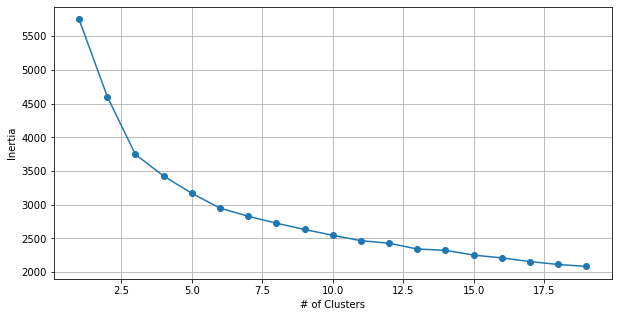

In [15]:
def optimize_kmeans(data, maxK): #Create a function for creating the elbow plot so that if we want to create another one in the future, we only need a function call
    num_cluster = []
    inertia = []

    for k in range(1, maxK):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data) #Fit the data into the kmeans model with k clusters

        num_cluster.append(k) #Add the number of clusters (k) to a list for graphing later
        inertia.append(kmeans.inertia_) #Add the inertia value to a list for graphing later

    #Graph the elbow plot, with inertia value as y-axis and number of clusters as x-axis
    fig = plt.subplots(figsize = (10, 5))
    plt.plot(num_cluster, inertia, 'o-')
    plt.xlabel('# of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

optimize_kmeans(scaled_df, 20) #Run the function on scaled_df and check the inertia value of 1-20 clusters

Based on the elbow plot, it seems like 6 clusters is where the elbow is. However, six clusters is too little for 250 NBA players and won't separate them enough based on all the features we are including. My reasoning is that if you simply cluster players by their position (PG, SG, SF, PF, C), that is already five clusters. Therefore, we need a lot more than 5 to properly separate the players using the 9 factors we are considering. I decided to use 10 as the number of clusters, since there is another slight elbow after 10. 

In [16]:
#Run the kmeans algorithm with 10 clusters, and random state = 1 so that we get consistent results which will allow us to compare different models
kmeans = KMeans(n_clusters = 10, random_state=1)
kmeans.fit(scaled_df)
y_kmeans = kmeans.predict(scaled_df)


In [17]:
#Create a new dataframe to see what cluster each player was put in
df_cluster = pd.DataFrame()
dfPlayerCol = scaled_df.reset_index()
df_cluster['name'] = dfPlayerCol['Name']
df_cluster['Cluster'] = y_kmeans
cluster_sorted= df_cluster.sort_values(by='Cluster', ascending=True)

#View the dataframe as a markdown file
print(cluster_sorted.to_markdown())

|     | name                     |   Cluster |
|----:|:-------------------------|----------:|
| 111 | Jakob Poeltl             |         0 |
|  52 | Daniel Gafford           |         0 |
| 206 | Paul Reed                |         0 |
| 198 | Onyeka Okongwu           |         0 |
|  67 | Dereck Lively II         |         0 |
|  79 | Drew Eubanks             |         0 |
|  84 | Evan Mobley              |         0 |
| 189 | Nick Richards            |         0 |
| 188 | Nic Claxton              |         0 |
| 101 | Isaiah Hartenstein       |         0 |
| 104 | Ivica Zubac              |         0 |
| 235 | Trayce Jackson-Davis     |         0 |
|  45 | Clint Capela             |         0 |
| 113 | Jalen Duren              |         0 |
| 183 | Moritz Wagner            |         0 |
| 213 | Rudy Gobert              |         0 |
| 155 | Kevon Looney             |         0 |
| 120 | James Wiseman            |         0 |
| 122 | Jarrett Allen            |         0 |
|  10 | Andre

To improve the model, we will use Principle Component Analysis to reduce the dimensionality of the model so we can visualize it in a scatterplot. 

In [18]:
#Run the PCA clustering with two components so we can visualize the clusters in a scatterplot
df_new_PCA = scaled_df.copy()
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_new_PCA)

kmeans = KMeans(n_clusters=10, random_state=1)
clusters = kmeans.fit_predict(pca_result) #Fit and predict with the PCA data 

pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters
pca_df['Name'] = dfPlayerCol['Name']

fig = px.scatter(pca_df, x='PCA1', y='PCA2', color='Cluster', title='PCA and KMeans Clustering', hover_data={'Name': True}) #Visualize the clusters in a scatter plot
fig.show()


To evaluate the model, we will use silhouette score and calinski scores. We will find those scores for a range of k (# of clusters) as well to better determine the ideal number of clusters. 

Number of clusters: 2, Silhouette Score: 0.3837614575147478
Number of clusters: 3, Silhouette Score: 0.47332853358236504
Number of clusters: 4, Silhouette Score: 0.3801078770502058
Number of clusters: 5, Silhouette Score: 0.3754252395374997
Number of clusters: 6, Silhouette Score: 0.3459453485259662
Number of clusters: 7, Silhouette Score: 0.356358133124799
Number of clusters: 8, Silhouette Score: 0.36177408584528303
Number of clusters: 9, Silhouette Score: 0.3769600621920923
Number of clusters: 10, Silhouette Score: 0.3726339769747353
Number of clusters: 11, Silhouette Score: 0.37326883256853516
Number of clusters: 12, Silhouette Score: 0.3493004020515458
Number of clusters: 13, Silhouette Score: 0.3596568888529649
Number of clusters: 14, Silhouette Score: 0.35600010133551746
Number of clusters: 15, Silhouette Score: 0.3513338921216665
Number of clusters: 16, Silhouette Score: 0.35054270014701255
Number of clusters: 17, Silhouette Score: 0.35310524136668237
Number of clusters: 18, Sil

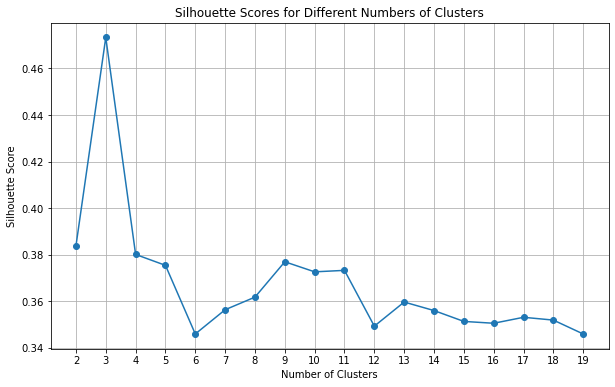

In [19]:
#Calculate the silhouette score, add them to a list, print out the silhouette score for each k value, then graph on a line chart. 
silhouette_scores = []

for k in range(2, 20): #Calculate the silhouette score for each number of clusters and append it to a list for visualization later
    kmeans = KMeans(n_clusters=k, random_state=1)
    cluster_labels = kmeans.fit_predict(pca_result)
    silhouette_avg = silhouette_score(pca_result, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"Number of clusters: {k}, Silhouette Score: {silhouette_avg}")

#Visualize the silhouette scores for different number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, 20))
plt.grid(True)
plt.show()

Based on the chart, 9 seems to be the ideal number of clusters since it has the highest score for clusters > 4

Number of clusters: 2, Calinski-Harabasz Score: 160.45286110724953
Number of clusters: 3, Calinski-Harabasz Score: 262.53435748965524
Number of clusters: 4, Calinski-Harabasz Score: 236.9700678123423
Number of clusters: 5, Calinski-Harabasz Score: 236.03930159805435
Number of clusters: 6, Calinski-Harabasz Score: 227.70520301438606
Number of clusters: 7, Calinski-Harabasz Score: 232.68853783725052
Number of clusters: 8, Calinski-Harabasz Score: 232.73843643785364
Number of clusters: 9, Calinski-Harabasz Score: 242.19988274747485
Number of clusters: 10, Calinski-Harabasz Score: 235.07438329607018
Number of clusters: 11, Calinski-Harabasz Score: 237.10228361479136
Number of clusters: 12, Calinski-Harabasz Score: 224.9295191502722
Number of clusters: 13, Calinski-Harabasz Score: 225.12167127659842
Number of clusters: 14, Calinski-Harabasz Score: 224.6151257509182
Number of clusters: 15, Calinski-Harabasz Score: 219.2231967836283
Number of clusters: 16, Calinski-Harabasz Score: 225.5846247

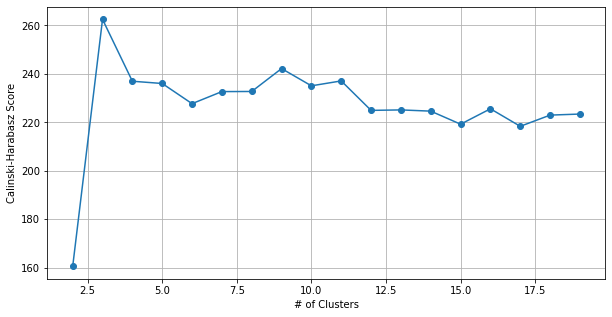

In [20]:
#Calculate the calinski score, add them to a list, print out the calinski score for each k value, then graph on a line chart. 
calinski_scores = []

for k in range(2, 20): #Calculate the calinski score for each number of clusters and append it to a list for visualization later
    kmeans = KMeans(n_clusters=k, random_state=1)
    cluster_labels = kmeans.fit_predict(pca_result)

    calinski_score = calinski_harabasz_score(pca_result, cluster_labels)
    calinski_scores.append(calinski_score)

    print(f"Number of clusters: {k}, Calinski-Harabasz Score: {calinski_score}")

#Visualize the calinski scores for different number of clusters
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(2, 20), calinski_scores, 'o-')
ax.set_xlabel('# of Clusters')
ax.set_ylabel('Calinski-Harabasz Score')
ax.grid(True)
plt.show()

Once again, 9 clusters seems to be the ideal number of clusters since it has the highest calinski score for more than 3 clusters. Let's run the PCA and kmeans clustering again with 9 clusters. 

In [21]:
#Create a new model with 9 clusters
kmeans = KMeans(n_clusters=9, random_state=1)
clusters = kmeans.fit_predict(pca_result)

pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters
pca_df['Name'] = dfPlayerCol['Name']

fig = px.scatter(pca_df, x='PCA1', y='PCA2', color='Cluster', title='PCA and KMeans Clustering', hover_data={'Name': True}) #Plot the new model in a scatter plot
fig.show()

In [22]:
#Create a new dataframe to see which cluster each player is put in
new_df_cluster = pd.DataFrame()
dfPlayerCol = scaled_df.reset_index()
new_df_cluster['name'] = dfPlayerCol['Name']
new_df_cluster['Cluster'] = clusters
new_cluster_sorted= new_df_cluster.sort_values(by='Cluster', ascending=True)

print(new_cluster_sorted.to_markdown())

|     | name                     |   Cluster |
|----:|:-------------------------|----------:|
|  59 | De'Andre Hunter          |         0 |
| 105 | Jabari Smith Jr.         |         0 |
|  35 | Caleb Martin             |         0 |
| 199 | P.J. Washington          |         0 |
| 197 | Ochai Agbaji             |         0 |
|  41 | Cedi O                   |         0 |
| 195 | OG Anunoby               |         0 |
|  44 | Christian Braun          |         0 |
| 103 | Isaiah Stewart           |         0 |
| 187 | Naz Reid                 |         0 |
| 186 | Naji Marshall            |         0 |
| 100 | Isaac Okoro              |         0 |
| 184 | Moses Moody              |         0 |
| 204 | Patrick Williams         |         0 |
|  98 | Herbert Jones            |         0 |
|  97 | Haywood Highsmith        |         0 |
|  56 | David Roddy              |         0 |
|  96 | Harrison Barnes          |         0 |
| 140 | Josh Hart                |         0 |
|  94 | Grant

To find out which players are the most similar to each other, we will use euclidean distance.  

In [23]:
#Create a function where you can enter a player name and it will output the 10 players with the highest similarity
def similar_players(player_name):
    player_pca1 = pca_df[pca_df['Name'] == player_name]['PCA1'].values[0] #Get the player's PCA1 value
    player_pca2 = pca_df[pca_df['Name'] == player_name]['PCA2'].values[0] #Get the player's PCA2 value

    # Calculate the distance of all players from the specified player
    pca_df['Distance'] = np.sqrt((pca_df['PCA1'] - player_pca1)**2 + (pca_df['PCA2'] - player_pca2)**2)

    # Exclude the specified player and sort by distance
    closest_players = pca_df[pca_df['Name'] != player_name].sort_values(by='Distance')

    # Get the list of closest player names
    closest_players_list = closest_players['Name'].tolist()

    # Return the top N closest players
    return closest_players_list[:10]

similar_players('LeBron James')

['Paolo Banchero',
 'Jimmy Butler',
 'Kevin Durant',
 'Kawhi Leonard',
 'Julius Randle',
 'DeMar DeRozan',
 'Jayson Tatum',
 'Nikola Jokic',
 'Jalen Williams',
 'Brandon Ingram']